In [1]:

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import numpy as np 
import pandas as pd
import os
import shutil
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import Xception

In [3]:
df = pd.read_csv('data_llhajbbbb.csv',sep=',' )

AUTO = tf.data.experimental.AUTOTUNE

In [4]:
df.head()

,image,lebels
0,new_data0.jpeg,rouille
1,new_data1.jpeg,rouille
2,new_data2.jpeg,rouille
3,new_data3.jpeg,rouille
4,new_data4.jpeg,rouille


In [5]:
a=df.copy()
a=pd.get_dummies(a['lebels'])
df1=pd.concat([df, a], axis=1)
df1.head()

,image,lebels,acariens,chancre fusicocum,coryneum,faux tigre,othyorinques,polystigma,puceron noir,puceron vert,rouille,scolytes
0,new_data0.jpeg,rouille,0,0,0,0,0,0,0,0,1,0
1,new_data1.jpeg,rouille,0,0,0,0,0,0,0,0,1,0
2,new_data2.jpeg,rouille,0,0,0,0,0,0,0,0,1,0
3,new_data3.jpeg,rouille,0,0,0,0,0,0,0,0,1,0
4,new_data4.jpeg,rouille,0,0,0,0,0,0,0,0,1,0


In [6]:
data=df1[df1['puceron noir']!=1]

In [7]:
data=data[data['othyorinques']!=1]

data=data[data['puceron vert']!=1]

In [8]:

data.drop(columns='lebels', inplace=True)
data.shape

(577, 11)

In [9]:
data.drop(columns=['puceron noir','othyorinques','puceron vert'],inplace=True)

In [10]:
data.head()

,image,acariens,chancre fusicocum,coryneum,faux tigre,polystigma,rouille,scolytes
0,new_data0.jpeg,0,0,0,0,0,1,0
1,new_data1.jpeg,0,0,0,0,0,1,0
2,new_data2.jpeg,0,0,0,0,0,1,0
3,new_data3.jpeg,0,0,0,0,0,1,0
4,new_data4.jpeg,0,0,0,0,0,1,0


In [11]:
data.columns

Index(['image', 'acariens', 'chancre fusicocum', 'coryneum', 'faux tigre',
       'polystigma', 'rouille', 'scolytes'],
      dtype='object')

<ipython-input-12-e50005ee8130>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pcts=data.mean()
C:\Users\zakaria\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1616: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


<AxesSubplot:ylabel='None'>

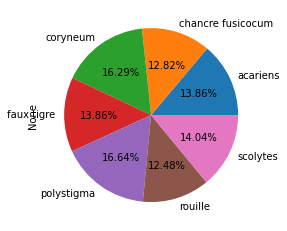

In [12]:
pcts=data.mean()
pcts.plot(kind = 'pie',autopct='%1.2f%%')

In [13]:
img_size={'height': 960,
         'width': 1280 }

In [14]:
data.shape

(577, 8)

In [15]:
path='path/'
data_path=data.image.apply(lambda x: path +x).values

(1280, 958, 3)


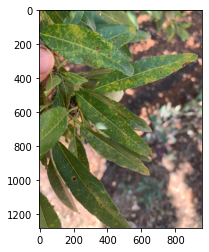

In [16]:
from matplotlib import pyplot as plt

img = plt.imread(path+'new_data1.jpeg')
print(img.shape)
plt.imshow(img)

In [17]:
data_path

array(['path/new_data0.jpeg', 'path/new_data1.jpeg',
       'path/new_data2.jpeg', 'path/new_data3.jpeg',
       'path/new_data4.jpeg', 'path/new_data5.jpeg',
       'path/new_data6.jpeg', 'path/new_data7.jpeg',
       'path/new_data8.jpeg', 'path/new_data9.jpeg',
       'path/new_data10.jpeg', 'path/new_data11.jpeg',
       'path/new_data12.jpeg', 'path/new_data13.jpeg',
       'path/new_data14.jpeg', 'path/new_data15.jpeg',
       'path/new_data16.jpeg', 'path/new_data17.jpeg',
       'path/new_data18.jpeg', 'path/new_data19.jpeg',
       'path/new_data20.jpeg', 'path/new_data21.jpeg',
       'path/new_data22.jpeg', 'path/new_data23.jpeg',
       'path/new_data24.jpeg', 'path/new_data25.jpeg',
       'path/new_data26.jpeg', 'path/new_data27.jpeg',
       'path/new_data28.jpeg', 'path/new_data29.jpeg',
       'path/new_data30.jpeg', 'path/new_data31.jpeg',
       'path/new_data32.jpeg', 'path/new_data33.jpeg',
       'path/new_data34.jpeg', 'path/new_data35.jpeg',
       'path/new_dat

In [18]:
data_labels = data.loc[:, ['acariens', 'chancre fusicocum', 'coryneum', 'faux tigre',
       'polystigma', 'rouille', 'scolytes']].values

In [19]:
train_paths, test_paths, train_labels, test_labels =train_test_split(data_path, data_labels, test_size=0.2, random_state=42)


In [20]:
len(test_paths)

116

In [29]:
IMG_SIZE=300
def decode_image(filename, label=None, IMG_SIZE=(IMG_SIZE, IMG_SIZE)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, IMG_SIZE)
    
    if label is None:
        return image
    else:
        return image, label


def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [30]:
BATCH_SIZE =8

train_dataset = (
tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_paths,test_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    
)

In [24]:
LR_START = 0.00001
LR_MAX = 0.0001 
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 15
LR_SUSTAIN_EPOCHS = 3
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [25]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow import keras
Den = keras.models.load_model('InceptionV3')

In [26]:
Den.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [31]:
y = Den.get_layer("global_average_pooling2d_4").output

#y = tf.keras.layers.Dense(1024, activation='softmax')(y)
y = tf.keras.layers.Dense(7, activation='softmax')(y)
model = keras.Model(inputs = Den.input,outputs=y)
model.compile( optimizer= 'adam',loss="categorical_crossentropy", metrics=["accuracy"])

In [32]:
history=model.fit(
    train_dataset,
    steps_per_epoch=data_labels.shape[0] // 8,
    epochs=40,
    validation_data=test_dataset
    )

Epoch 1/40
72/72 [==============================] - 34s 230ms/step - loss: 1.7847 - accuracy: 0.2535 - val_loss: 1.8202 - val_accuracy: 0.2155
Epoch 2/40
72/72 [==============================] - 15s 205ms/step - loss: 1.5382 - accuracy: 0.3698 - val_loss: 7.4649 - val_accuracy: 0.1552
Epoch 3/40
72/72 [==============================] - 15s 207ms/step - loss: 1.4416 - accuracy: 0.4236 - val_loss: 1.5379 - val_accuracy: 0.4224
Epoch 4/40
72/72 [==============================] - 15s 205ms/step - loss: 1.2383 - accuracy: 0.4983 - val_loss: 1.3815 - val_accuracy: 0.4483
Epoch 5/40
72/72 [==============================] - 15s 206ms/step - loss: 1.1400 - accuracy: 0.5330 - val_loss: 1.4047 - val_accuracy: 0.4741
Epoch 6/40
72/72 [==============================] - 15s 207ms/step - loss: 1.0271 - accuracy: 0.5816 - val_loss: 1.5185 - val_accuracy: 0.4655
Epoch 7/40
72/72 [==============================] - 15s 205ms/step - loss: 0.9976 - accuracy: 0.6042 - val_loss: 1.4912 - val_accuracy: 0.5345

In [33]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        #plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

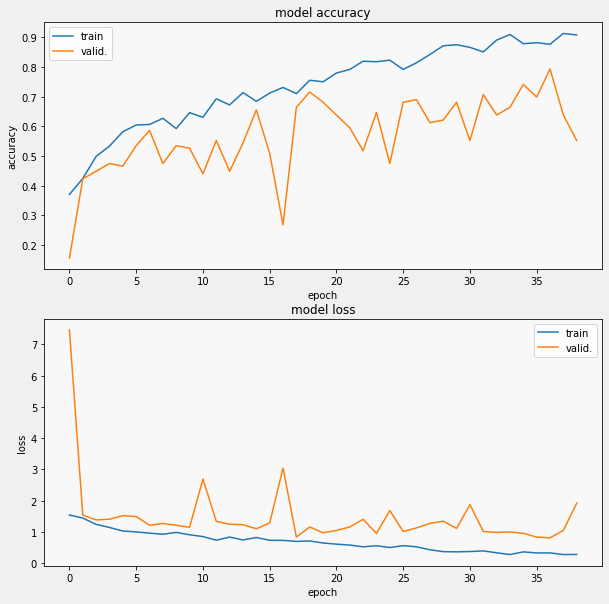

In [34]:
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

In [35]:
import pickle
with open('training_log/InceptionV3_new_withoutlayer_40_300px.pkl', 'wb') as output:
        pickle.dump(history.history, output)